<h1> <center> Forecasting Future Order Quantity for a Bike Store Chain using Gradient Boosting Regression </center> </h1>

###### <u> Problem Statement </u> : The bike store chain, operating between the years 2011 and 2015, has accumulated a significant amount of historical sales data. To optimize inventory management and meet customer demand effectively, the company aims to develop a predictive model capable of forecasting the order quantity for future periods. So that they can accurately stock up their inventory with relevant accessories and Bikes.

###### <u> Objective: </u> The primary objective of this project is to create a robust Gradient Boosting Regression model that can accurately predict the order quantity for the bike store chain's products in upcoming periods.

In [129]:
#installing necessary dpendencies
!pip install opendatasets
!pip install xgboost
!pip install jovian
!pip install joblib

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


     ---------------------------------------- 0.0/68.6 kB ? eta -:--:--
     ---------------------- --------------- 41.0/68.6 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 68.6/68.6 kB 941.6 kB/s eta 0:00:00
  Using cached uuid-1.30.tar.gz (5.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6484 sha256=9edf096f86f50a247ad030b6052e03e74f5c5f948d0186b5d14d762943b9d0ac
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\e0\01\df\bd20df409bd81f8b99e6cd343c5f49731dc0a20eefefdafae0
Successfully built uuid


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
#importing required modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as opt
import opendatasets as od
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import joblib
import jovian

In [2]:
#downloading the data usig opendatasets library

od.download('https://www.kaggle.com/datasets/sadiqshah/bike-sales-in-europe/download?datasetVersionNumber=1')
os.listdir('bike-sales-in-europe')

Skipping, found downloaded files in ".\bike-sales-in-europe" (use force=True to force download)


['Sales.csv']

In [3]:
#parsing the INPUT DATA sheet as dataframe using pandas

df = pd.read_csv("bike-sales-in-europe/Sales.csv")
df

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2013-11-26,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
1,2015-11-26,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
2,2014-03-23,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366,1035,2401
3,2016-03-23,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188,900,2088
4,2014-05-15,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238,180,418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113031,2016-04-12,12,April,2016,41,Adults (35-64),M,United Kingdom,England,Clothing,Vests,"Classic Vest, S",3,24,64,112,72,184
113032,2014-04-02,2,April,2014,18,Youth (<25),M,Australia,Queensland,Clothing,Vests,"Classic Vest, M",22,24,64,655,528,1183
113033,2016-04-02,2,April,2016,18,Youth (<25),M,Australia,Queensland,Clothing,Vests,"Classic Vest, M",22,24,64,655,528,1183
113034,2014-03-04,4,March,2014,37,Adults (35-64),F,France,Seine (Paris),Clothing,Vests,"Classic Vest, L",24,24,64,684,576,1260


In [4]:
df.describe()

,Day,Year,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
count,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000
mean,15.665753,2014.401739,35.919212,11.901660,267.296366,452.938427,285.051665,469.318695,754.370360
std,8.781567,1.272510,11.021936,9.561857,549.835483,922.071219,453.887443,884.866118,1309.094674
min,1.000000,2011.000000,17.000000,1.000000,1.000000,2.000000,-30.000000,1.000000,2.000000
25%,8.000000,2013.000000,28.000000,2.000000,2.000000,5.000000,29.000000,28.000000,63.000000
50%,16.000000,2014.000000,35.000000,10.000000,9.000000,24.000000,101.000000,108.000000,223.000000
75%,23.000000,2016.000000,43.000000,20.000000,42.000000,70.000000,358.000000,432.000000,800.000000
max,31.000000,2016.000000,87.000000,32.000000,2171.000000,3578.000000,15096.000000,42978.000000,58074.000000


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113036 entries, 0 to 113035
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Date              113036 non-null  object
 1   Day               113036 non-null  int64 
 2   Month             113036 non-null  object
 3   Year              113036 non-null  int64 
 4   Customer_Age      113036 non-null  int64 
 5   Age_Group         113036 non-null  object
 6   Customer_Gender   113036 non-null  object
 7   Country           113036 non-null  object
 8   State             113036 non-null  object
 9   Product_Category  113036 non-null  object
 10  Sub_Category      113036 non-null  object
 11  Product           113036 non-null  object
 12  Order_Quantity    113036 non-null  int64 
 13  Unit_Cost         113036 non-null  int64 
 14  Unit_Price        113036 non-null  int64 
 15  Profit            113036 non-null  int64 
 16  Cost              113036 non-null  int

###### So looking at the above cells we could figure out, that we have a few categorical columns, and a bunch of numerical columns, that we'll look at later, to choose which we will keep during training the model


In [6]:
df.isna().sum()

Date                0
Day                 0
Month               0
Year                0
Customer_Age        0
Age_Group           0
Customer_Gender     0
Country             0
State               0
Product_Category    0
Sub_Category        0
Product             0
Order_Quantity      0
Unit_Cost           0
Unit_Price          0
Profit              0
Cost                0
Revenue             0
dtype: int64

###### No, column has any NaN values, this means no Imputation needed for this dataset

In [7]:
years = df['Year'].value_counts()
years

2014    29398
2016    29398
2013    24443
2015    24443
2012     2677
2011     2677
Name: Year, dtype: int64

###### So this dataset contains data from six years from 2011 to 2016, we'll keep data till 2015 as our training data and split the data for year 2016 into wo equal halves for testing and validation, as it has a quite large number of data points

# <b> Exploratory Data Analysis


#### <b> Country-wise Profits </b>

In [10]:
country = df.groupby("Country")['Order_Quantity'].sum().reset_index().sort_values(by=['Order_Quantity'], ascending =True)
country.set_index('Country', inplace=True)
country["%"] = country["Order_Quantity"]*100/country["Order_Quantity"].sum()
country

,Order_Quantity,%
Country,,
Germany,125720,9.345016
France,128995,9.588454
United Kingdom,157218,11.686325
Canada,192259,14.290992
Australia,263585,19.592795
United States,477539,35.496419


###### This Dataset contains data from stores from 6 different countries, let's plot a graph to look at country-wise share of the profit 

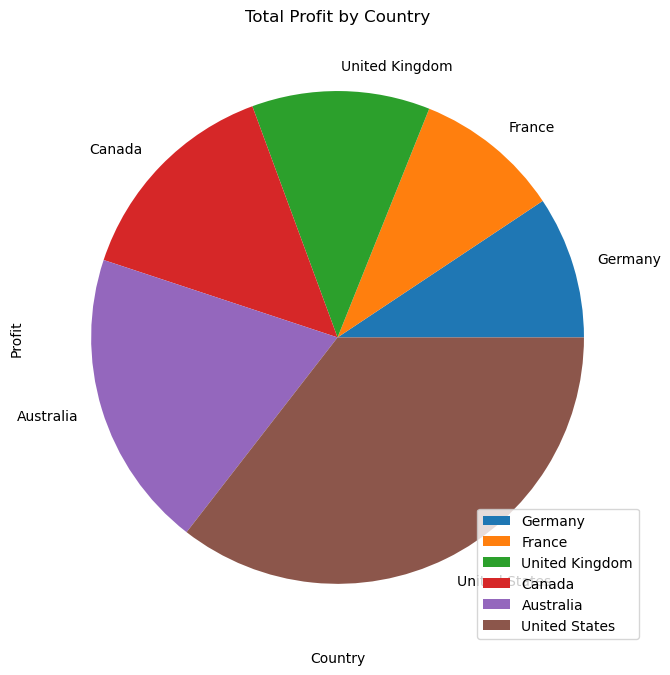

In [9]:
country.plot(kind='pie', x='Country', y='Order_Quantity', figsize=(12,8))
plt.xlabel("Country")
plt.ylabel("Profit")
plt.title("Total Profit by Country")
plt.show()

###### As we can see profits earned by stores in the US are much Higher than that of other countries, followed by Austalia. In fact the profit earned by the US stores (maximum profit) is almost 5 times the profit earned by stores in France (minimum profit). <br>

###### One of the main reason behind this could be lesser population and land mass of european countries as compared to Australia or America

#### Product-wise Profits

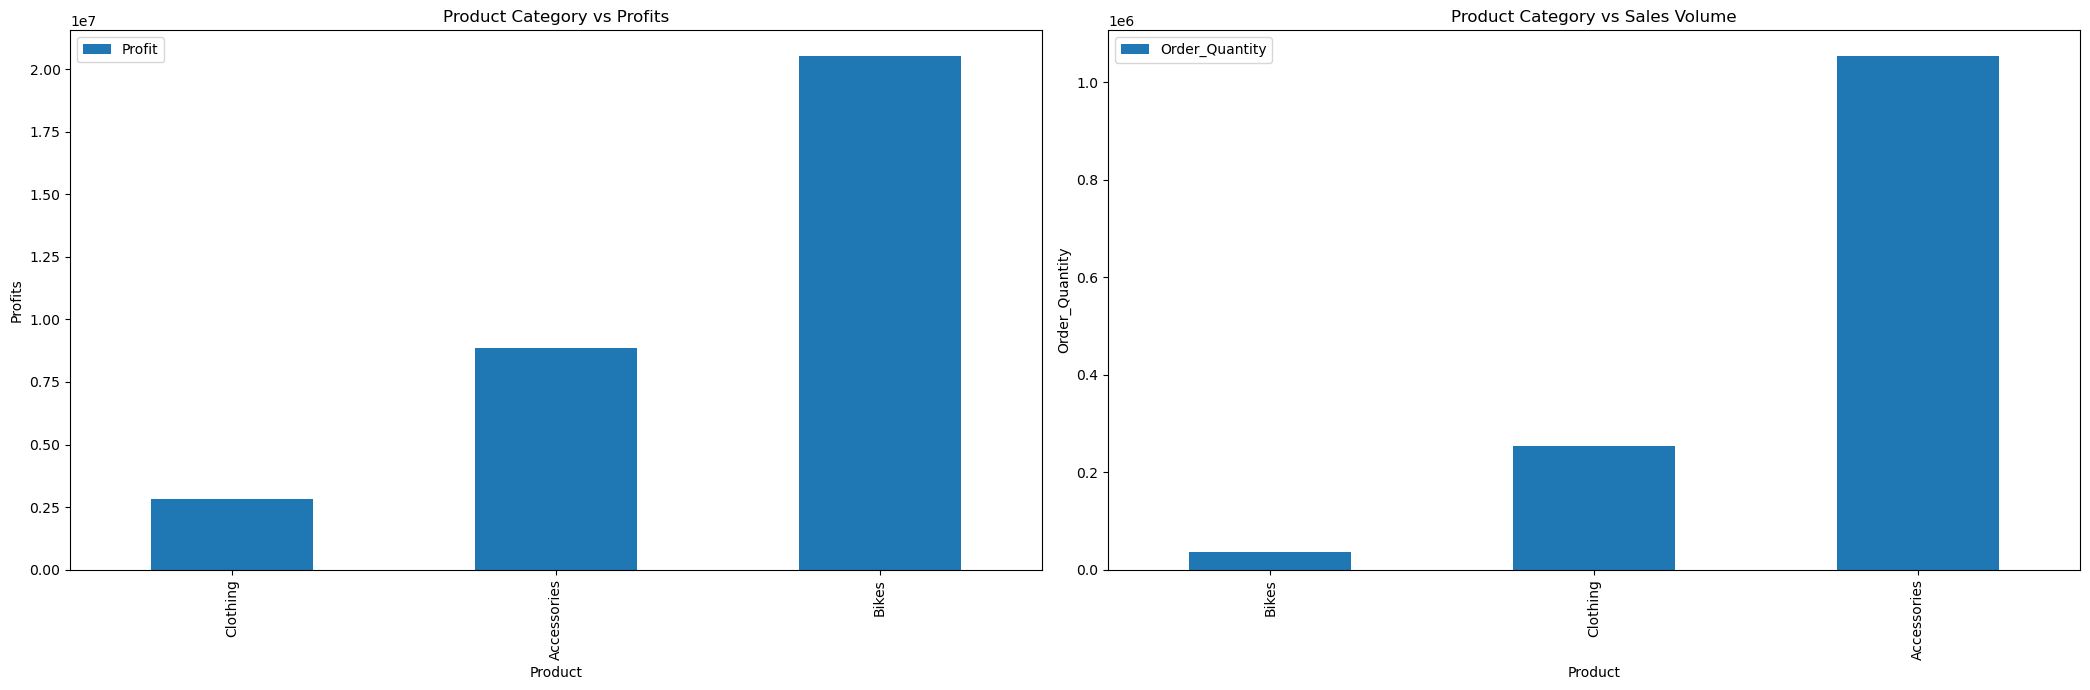

In [12]:
Product_Category_Profit = df.groupby("Product_Category")['Profit'].sum().reset_index().sort_values(by=['Profit'], ascending =True)
Product_Category_Sales = df.groupby("Product_Category")['Order_Quantity'].sum().reset_index().sort_values(by=['Order_Quantity'], ascending =True)
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

# Plot the top 10 products in the left subplot
Product_Category_Profit.plot(kind='bar', x='Product_Category', y='Profit', ax=axes[0])
axes[0].set_xlabel("Product")
axes[0].set_ylabel("Profits")
axes[0].set_title("Product Category vs Profits")

# Plot the bottom 10 products in the right subplot
Product_Category_Sales .plot(kind='bar', x='Product_Category', y='Order_Quantity', ax=axes[1])
axes[1].set_xlabel("Product")
axes[1].set_ylabel("Order_Quantity")
axes[1].set_title("Product Category vs Sales Volume")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
Product_Category_Profit

,Product_Category,Profit
2,Clothing,2839447
0,Accessories,8862377
1,Bikes,20519276


###### Bike stores have three main product categories, Bikes, Clothings and accessories, the distribution of Profits and Sales Volume across these three categories makes sense, a bike sale tends to bring in more profit than sales of clothings and accessories, and we can see this clearly in the charts

In [14]:
Bikes =  df[df['Product_Category'] == "Bikes"]
Bikes = Bikes.groupby("Product")[['Order_Quantity','Profit']].sum().reset_index().sort_values(by=['Order_Quantity'], ascending =True)
Products =  df[df['Product_Category'] != "Bikes"]
Products = Products.groupby("Product")[['Order_Quantity','Profit']].sum().reset_index().sort_values(by=['Order_Quantity'], ascending =True)

print("Bikes :",len(Bikes),"Products :" ,len(Products))

Bikes : 88 Products : 43


In [15]:
max_profit_index = Bikes['Profit'].idxmax()
min_profit_index = Bikes['Profit'].idxmin()

max_profit = Bikes.loc[max_profit_index, 'Product']
min_profit = Bikes.loc[min_profit_index, 'Product']

print(max_profit,min_profit)

Mountain-200 Black, 38 Mountain-500 Black, 52


#### Bike which earned the most porfit : `Mountain-200 Black, 38` <br>
#### Bike which earned the least porfit : `Mountain-500 Black, 52` <br>

In [16]:
max_index = Bikes['Order_Quantity'].idxmax()
min_index = Bikes['Order_Quantity'].idxmin()

max_sales = Bikes.loc[max_index, 'Product']
min_sales = Bikes.loc[min_index, 'Product']

print(max_sales,min_sales)

Mountain-200 Black, 38 Mountain-500 Black, 52


#### So including all the stores across all countires, there are `88` different options for Bikes and `43` different options for Accessories and Clothings to buy from avaialble for cutomers

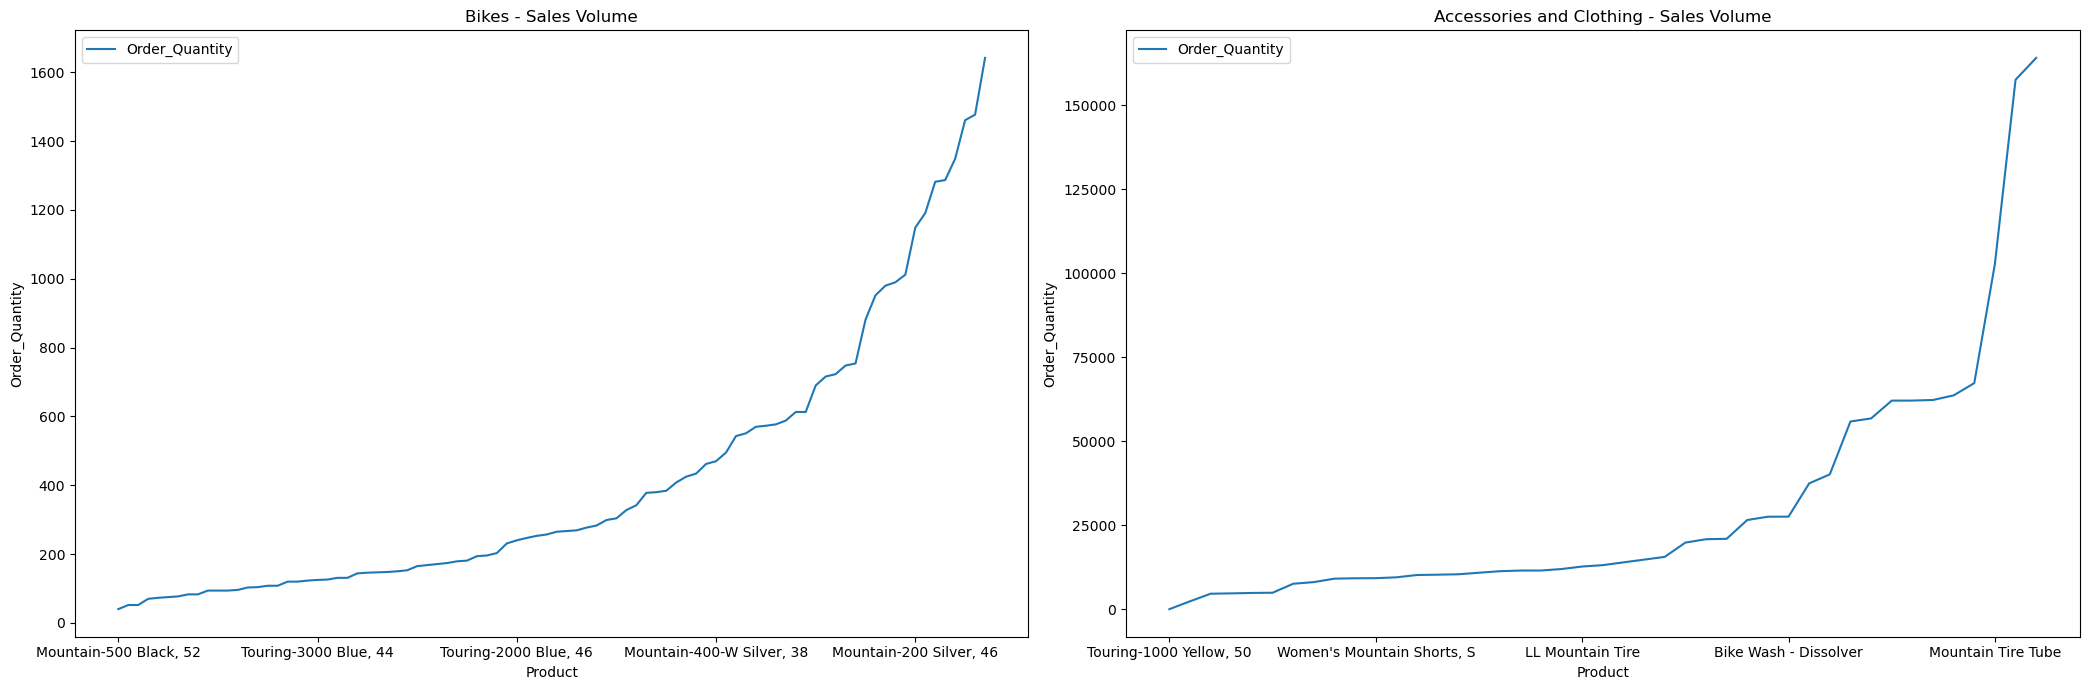

In [17]:
import matplotlib.pyplot as plt

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

# Plot the top 10 products in the left subplot
Bikes.plot(kind='line', x='Product', y='Order_Quantity', ax=axes[0])
axes[0].set_xlabel("Product")
axes[0].set_ylabel("Order_Quantity")
axes[0].set_title("Bikes - Sales Volume")

# Plot the bottom 10 products in the right subplot
Products.plot(kind='line', x='Product', y='Order_Quantity', ax=axes[1])
axes[1].set_xlabel("Product")
axes[1].set_ylabel("Order_Quantity")
axes[1].set_title("Accessories and Clothing - Sales Volume")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### Even though we observed that a major chunk of Profits is coming from Bikes sales, but total sales volume is approx 100 times higher for Accessories and Clothings when compared to Bikes sales Volume. <br>

#### And it absolutely makes sense, as a bike is a one time purchase and people usually use same bike atleast for a year or (years), But the need for accessories and other related products have more demand and purchased multiple times

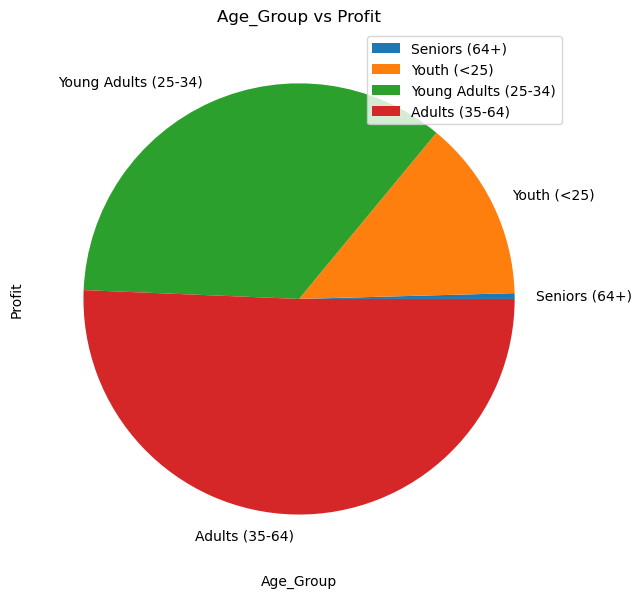

In [23]:
Age_Group = df.groupby("Age_Group")[['Revenue','Profit']].sum().reset_index().sort_values(by=['Revenue'], ascending =True)
Age_Group.set_index('Age_Group', inplace=True)
Age_Group.plot(kind='pie', x='Age_Group', y='Profit', figsize=(10,7))
plt.xlabel("Age_Group")
plt.ylabel("Profit")
plt.title("Age_Group vs Profit")
plt.show()

In [37]:
Gender = df.groupby("Customer_Gender")[['Revenue']].sum().reset_index().sort_values(by=['Revenue'], ascending =True)
Gender["Revenue %"] = Gender["Revenue"]*100/Gender["Revenue"].sum()
Gender

,Customer_Gender,Revenue,Revenue %
0,F,41935599,49.179199
1,M,43335409,50.820801


In [25]:
Age_Group["% Revenue"] = Age_Group["Revenue"]*100/Age_Group["Revenue"].sum()
Age_Group

,Revenue,Profit,% Revenue
Age_Group,,,
Seniors (64+),308042,138165,0.361251
Youth (<25),11723199,4374592,13.748165
Young Adults (25-34),30655614,11386761,35.950805
Adults (35-64),42584153,16321582,49.939779


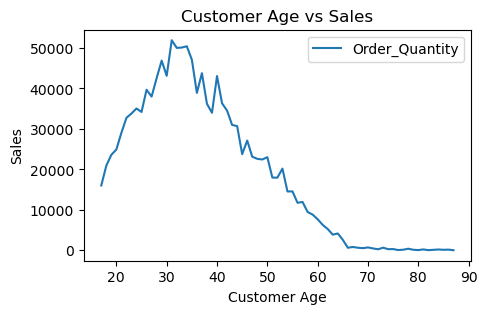

In [16]:
Age_Group = df.groupby("Customer_Age")['Order_Quantity'].sum().reset_index().sort_values(by=['Customer_Age'], ascending =True)
Age_Group.plot(kind='line', x='Customer_Age', y='Order_Quantity', figsize=(5,3))
plt.xlabel("Customer Age")
plt.ylabel("Sales")
plt.title("Customer Age vs Sales")
plt.show()

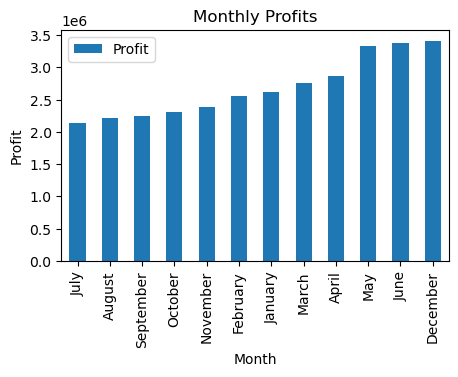

In [17]:
Monthly_Profits = df.groupby("Month")[['Revenue','Profit']].sum().reset_index().sort_values(by=['Profit'], ascending =True)
Monthly_Profits.plot(kind='bar', x='Month', y='Profit', figsize=(5,3))
plt.xlabel("Month")
plt.ylabel("Profit")
plt.title("Monthly Profits")
plt.show()

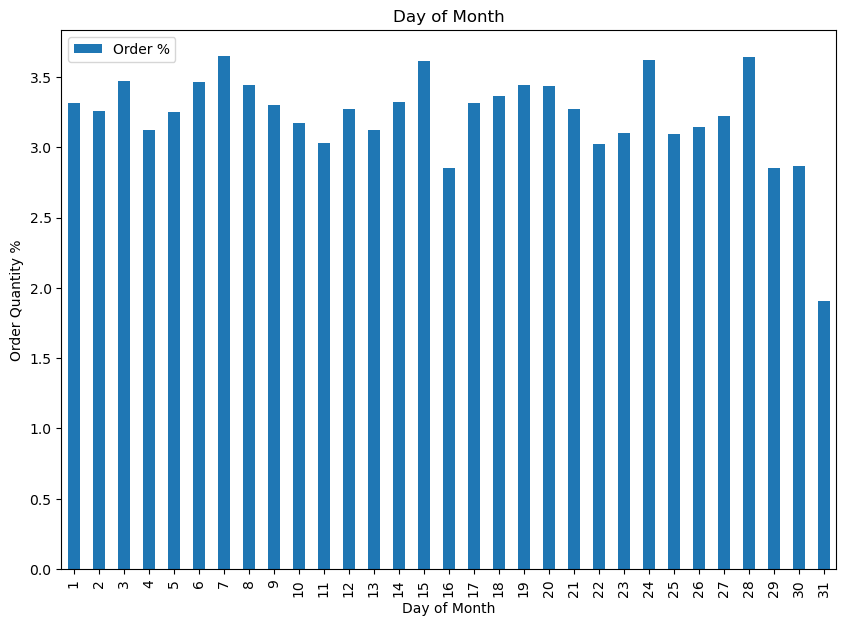

In [33]:
day_of_month = df.groupby("Day")[['Order_Quantity']].sum().reset_index().sort_values(by=['Day'], ascending =True)
day_of_month["Order %"] = day_of_month["Order_Quantity"]*100/day_of_month["Order_Quantity"].sum()
day_of_month.plot(kind='bar', x='Day', y='Order %', figsize=(10,7))
plt.xlabel("Day of Month")
plt.ylabel("Order Quantity %")
plt.title("Day of Month")
plt.show()

In [34]:
day_of_month

,Day,Order_Quantity,Order %
0,1,44590,3.314463
1,2,43859,3.260126
2,3,46680,3.469817
3,4,42000,3.121943
4,5,43738,3.251132
5,6,46631,3.466174
6,7,49126,3.651633
7,8,46334,3.444098
8,9,44445,3.303685
9,10,42632,3.168921


#### Months of Decemebr, May and June have proven to be more profitable, while July, August and September being the least profitable ones.

# <b> Data Preprocessing </b>

In [18]:
df

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2013-11-26,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
1,2015-11-26,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
2,2014-03-23,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366,1035,2401
3,2016-03-23,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188,900,2088
4,2014-05-15,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238,180,418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113031,2016-04-12,12,April,2016,41,Adults (35-64),M,United Kingdom,England,Clothing,Vests,"Classic Vest, S",3,24,64,112,72,184
113032,2014-04-02,2,April,2014,18,Youth (<25),M,Australia,Queensland,Clothing,Vests,"Classic Vest, M",22,24,64,655,528,1183
113033,2016-04-02,2,April,2016,18,Youth (<25),M,Australia,Queensland,Clothing,Vests,"Classic Vest, M",22,24,64,655,528,1183
113034,2014-03-04,4,March,2014,37,Adults (35-64),F,France,Seine (Paris),Clothing,Vests,"Classic Vest, L",24,24,64,684,576,1260


In [19]:
years = df['Year'].value_counts()
years

2014    29398
2016    29398
2013    24443
2015    24443
2012     2677
2011     2677
Name: Year, dtype: int64

###### We have Profits, Revenue, and Order Quanitity in our dataset, I am choosing Order Quantity as the Target Column, why because, Revenue and Profits can be calculated using Unit Cost, Cost and Unit Price Columns, also this will result in less complex models as we are reducing number of features

In [20]:
target_col = ['Order_Quantity']

In [21]:
from sklearn.model_selection import train_test_split

train_df = df[df['Year'] < 2016]
test_val_df = df[df['Year'] == 2016]
test_df, val_df = train_test_split(test_val_df, test_size=0.50, random_state=42)

###### Splitting the dataset into Train, Test and Validation set, keeping data till 2015 as our training data and split the data for the year 2016 into two equal halves for testing and validation, as it has a quite large number of data points

In [22]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(83638, 18)
(14699, 18)
(14699, 18)


In [23]:
train_df = train_df.drop(['Date','Year','Unit_Cost','Cost','Profit','Revenue'],axis=1)
test_df = test_df.drop(['Date','Year','Unit_Cost','Cost','Profit','Revenue'],axis=1)
val_df = val_df.drop(['Date','Year','Unit_Cost','Cost','Profit','Revenue'],axis=1)

###### Since we have separate columns for Month and Day and we have split the data based on year, the date and year column, so  now we can remove these columns from input data, also removing Unit Cost, Cost , Revenue and Profit colmns from the input features as, Cost of an item, is least likely to govern the decision of buying a product for any customer, what customers look at is the Unit Price  that they need to pay and that have been added to input features, and for Profit and Revenue, these are just dependent columns and can be calculated by simple arithmetic formula, so skipping them as well

In [24]:
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes('object').columns.tolist()
input_cols = numeric_cols  + categorical_cols
input_cols.remove('Order_Quantity')
numeric_cols.remove('Order_Quantity')


###### Extracting Numeric and Categorical Columns from input data and also removing target column from the input data

In [25]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [26]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].to_numpy()

In [27]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df[['Unit_Price']])
train_inputs['Unit_Price'] = scaler.transform(train_inputs[['Unit_Price']])
val_inputs['Unit_Price'] = scaler.transform(val_inputs[['Unit_Price']])
test_inputs['Unit_Price'] = scaler.transform(test_inputs[['Unit_Price']])

###### Scaling the Numeric Columns, here we only scaling Unit Price, not scaling down Day, and Customer Age values as these values lie in a very small range day (1-31), age (16-87) 

In [29]:
print("Numeric Columns : ",numeric_cols,"\n","Categorical Columns : ",categorical_cols)

Numeric Columns :  ['Day', 'Customer_Age', 'Unit_Price'] 
 Categorical Columns :  ['Month', 'Age_Group', 'Customer_Gender', 'Country', 'State', 'Product_Category', 'Sub_Category', 'Product']


In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Month_April', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September', 'Age_Group_Adults (35-64)', 'Age_Group_Seniors (64+)', 'Age_Group_Young Adults (25-34)', 'Age_Group_Youth (<25)', 'Customer_Gender_F', 'Customer_Gender_M', 'Country_Australia', 'Country_Canada', 'Country_France', 'Country_Germany', 'Country_United Kingdom', 'Country_United States', 'State_Alabama', 'State_Alberta', 'State_Arizona', 'State_Bayern', 'State_Brandenburg', 'State_British Columbia', 'State_California', 'State_Charente-Maritime', 'State_England', 'State_Essonne', 'State_Florida', 'State_Garonne (Haute)', 'State_Georgia', 'State_Hamburg', 'State_Hauts de Seine', 'State_Hessen', 'State_Illinois', 'State_Kentucky', 'State_Loir et Cher', 'State_Loiret', 'State_Massachusetts', 'State_Minnesota', 'State_Mississippi', 'State_Missouri', 'State_Montana', 'State_Moselle', 'State_New South Wales

###### Performing One Hot Encoding on the categorical columns, in order to use it in our model training

In [31]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\asus\AppData\Local\Temp\ipykernel_14700\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\asus\AppData\Local\Temp\ipykernel_14700\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\asus\AppData\Local\Temp\ipykernel_14700\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [32]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Model 1: Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf_1 = RandomForestRegressor(n_jobs=-1, random_state=42)

###### Starting with a very basic model, with no hyperparameter values set initially

In [34]:
rf_1.fit(X_train, train_targets)

C:\Users\asus\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [35]:
train_preds=rf_1.predict(X_train)
val_preds = rf_1.predict(X_val)
test_preds = rf_1.predict(X_test)

In [36]:
rf1_val_rmse = mean_squared_error(val_targets,val_preds, squared=False)
rf1_train_rmse = mean_squared_error(train_targets,train_preds, squared=False)
rf1_test_rmse = mean_squared_error(test_targets,test_preds,squared = False)

In [37]:
print(rf1_train_rmse,rf1_val_rmse,rf1_test_rmse)

4.057023278366785 4.742232140067803 4.800880597106752


In [38]:
rf1_val_r2 = r2_score(val_targets,val_preds)
rf1_train_r2 = r2_score(train_targets,train_preds)
rf1_test_r2 = r2_score(test_targets,test_preds)

In [39]:
print(rf1_train_r2,rf1_val_r2,rf1_test_r2)

0.8221180349581781 0.7431867177291631 0.7370338688292092


###### So we get an r2_score of :
###### `82.21%` on Training Data <br>
###### `74.31%` on Validation Data <br>
###### `73.70%` on Test Data <br>
######  Which is decent for a start, now first compare it against a dumb model and then we'll look into hyperparameter tuning

In [40]:
X_mean_train = np.full(len(X_train),df['Order_Quantity'].mean())


###### Let's take a model, which gives out average of the entire Order Quantity as the output, for any input

In [41]:
dumb_rmse = mean_squared_error(train_targets,X_mean_train, squared=False)
dumb_r2 = r2_score(train_targets,X_mean_train)
print(dumb_rmse,dumb_r2)

9.622511169233078 -0.0006766521951999671


###### As we can see from RMSE and r2_score values, our Base model performs better thana dumb model, so now let's move to hyperparameter tuning and see if we can further improve the performance of our model

In [42]:
important_ft = pd.DataFrame({"Feature" : X_train.columns, "Importance" : rf_1.feature_importances_}).sort_values(by="Importance",ascending=False).reset_index()
important_ft

,index,Feature,Importance
0,2,Unit_Price,4.695852e-01
1,0,Day,1.093565e-01
2,1,Customer_Age,7.953156e-02
3,12,Month_November,1.005317e-02
4,4,Month_August,9.549304e-03
...,...,...,...
225,125,"Product_Mountain-100 Black, 42",2.696017e-07
226,217,"Product_Touring-3000 Blue, 50",2.171577e-07
227,218,"Product_Touring-3000 Blue, 54",1.972350e-07
228,224,"Product_Touring-3000 Yellow, 58",1.385618e-07


###### So our model has 230 features in total, out of which these are the 10 with highest importance scores 

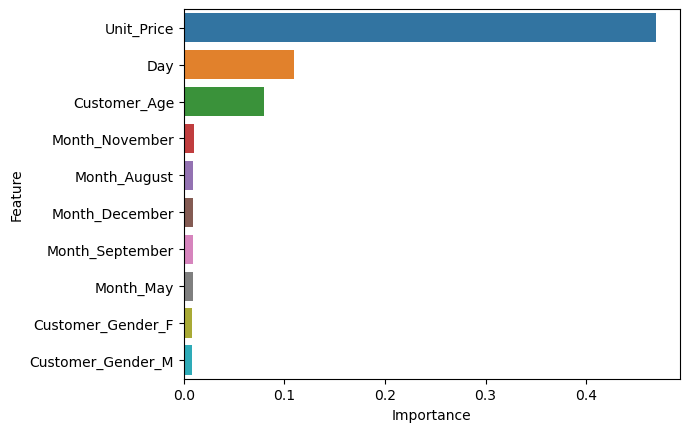

In [122]:
important_ft = pd.DataFrame({"Feature" : X_train.columns, "Importance" : rf_1.feature_importances_}).sort_values(by="Importance",ascending=False).reset_index()
features_post_tuning = important_ft.head(10)['Feature'].to_list()
sns.barplot(data=important_ft.head(10), x='Importance', y='Feature');

# Hyperparameter Tuning : Model 1

In [45]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets.values.ravel())
    train_rmse = mean_squared_error(model.predict(X_train), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val), val_targets, squared=False)
    return train_rmse, val_rmse

In [46]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        print(value,train_rmse, val_rmse)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

###### Lets make use of these functions to try and test different values for different hyperparameters

5 4.46580238357964 5.286521762620613
10 4.2581666134060105 5.017670315382427
20 4.14566465235571 4.861176855657937
50 4.080496426177036 4.766607827951333
70 4.067359254152548 4.753391227817475
100 4.057023278366785 4.742232140067803
200 4.046066061956009 4.727062110615547
300 4.042521851693764 4.723715098074292


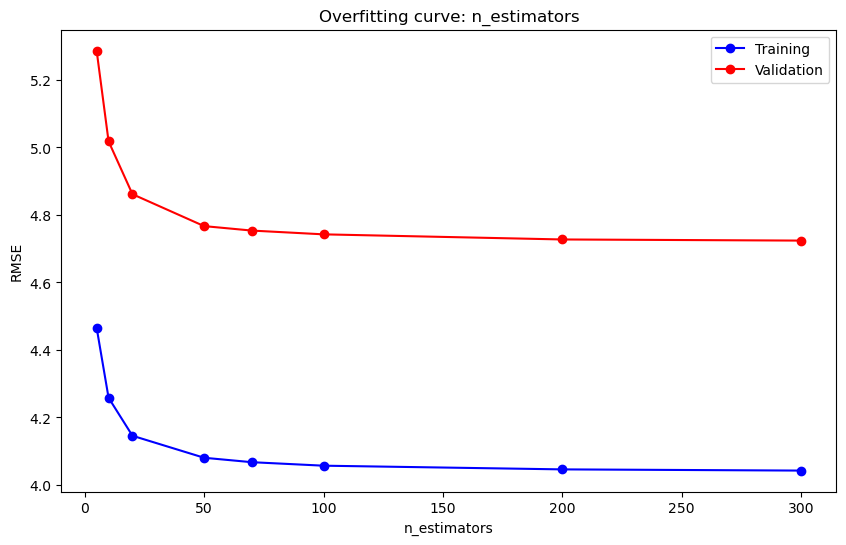

In [123]:
test_param_and_plot('n_estimators', [5,10,20,50,70,100,200,300]) #best =200

##### Increasing the n_estimators steeply decreases the RMSE value and then stays contant after a point, so we'll stick to 200, as post that increment isnt much

0.2 4.059146637322239 4.747762846194249
0.3 4.05920424421067 4.749195187147896
0.4 4.056273009124313 4.743563272207282
log2 4.072451772701309 4.778218031979046
10 4.071051771421085 4.774071080246127
15 4.067828768365155 4.764413605282839
sqrt 4.067828768365155 4.764413605282839
20 4.066655807823873 4.766741966449202
40 4.060435103494421 4.749363044720957
50 4.059564998546424 4.747553243122462
60 4.058036865363243 4.750016969986289
80 4.05712382567593 4.742643019888872
100 4.057317307689215 4.749248224393459
150 4.057526631940254 4.745859924653633
200 4.057364933272105 4.744651394341827


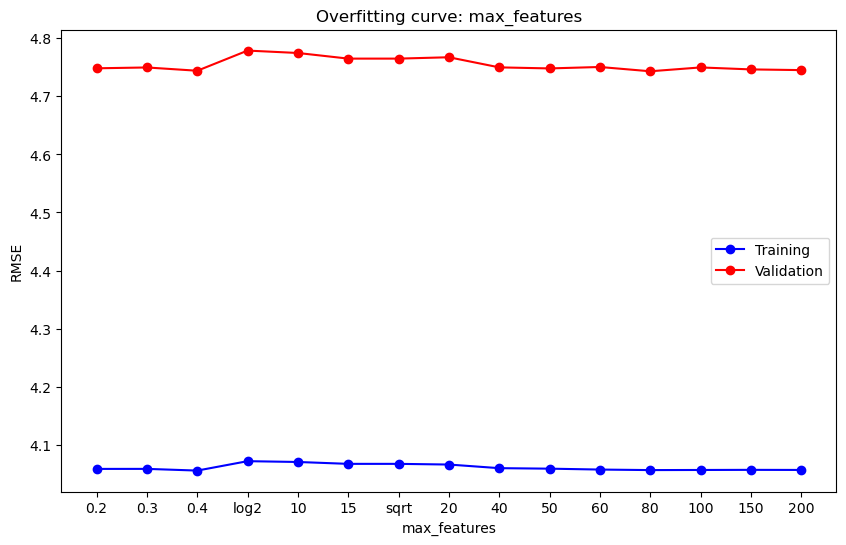

In [124]:
test_param_and_plot('max_features', [0.2, 0.3, 0.4,'log2',10,15,'sqrt',20,40,50,60,80,100,150,200]) #best=80

##### max_featuresvalue of 80 results in comparetively lower value of RMSE

50 4.087678304935623 4.792415523978178
100 4.057023278366785 4.742232140067803
150 4.057023278366785 4.742232140067803
200 4.057023278366785 4.742232140067803
250 4.057023278366785 4.742232140067803
300 4.057023278366785 4.742232140067803


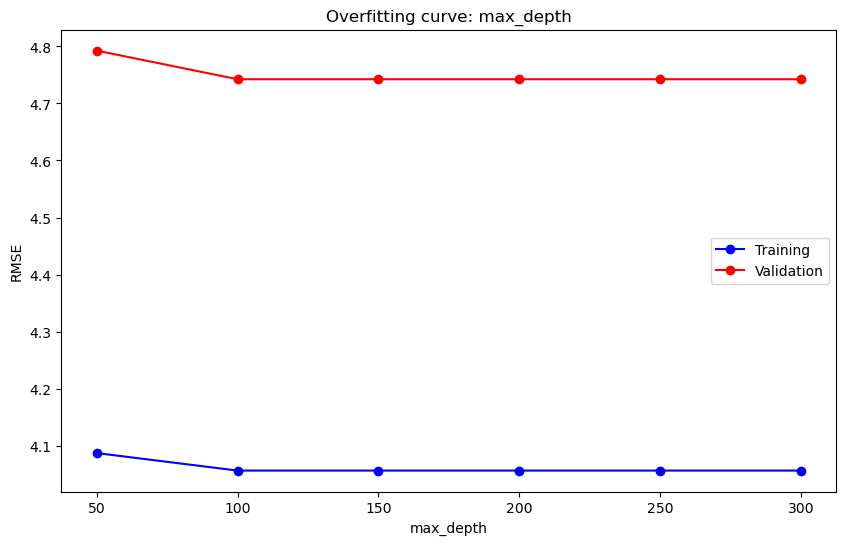

In [126]:
test_param_and_plot('max_depth', [50,100,150,200,250,300]) #best=100

##### We'll continue with max depth of 100

0.01 7.360825235138659 7.926797844294444
0.001 4.335403214892713 5.113203314918031
0.0001 4.076547515530575 4.759029704287006
1e-05 4.058694978512803 4.744111033337279
1e-06 4.057041350882553 4.743187331792471
1e-07 4.056872232401336 4.742352055088594
1e-08 4.056674644819369 4.742802310229318


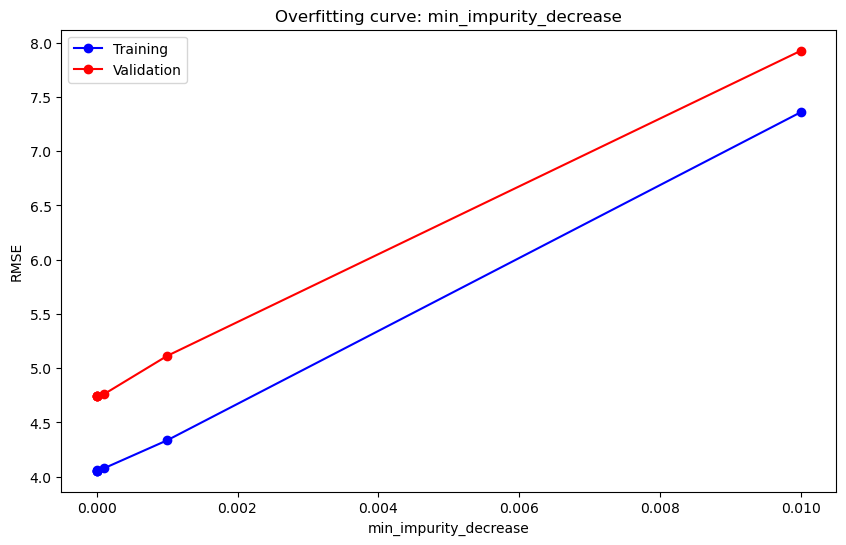

In [128]:
test_param_and_plot('min_impurity_decrease', [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]) #best=1e-7

###### Now that we have an optimal value for each hyperparamater lets train a new model , with these hyperparamters and see 

In [47]:
rf_2= RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=200, max_depth= 100, max_features=80,min_samples_split=2,min_impurity_decrease=1e-7)

In [48]:
rf_2.fit(X_train,train_targets.values.ravel())

RandomForestRegressor(max_depth=100, max_features=80,
                      min_impurity_decrease=1e-07, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [49]:
train_preds_rf2=rf_2.predict(X_train)
val_preds_rf2 = rf_2.predict(X_val)
test_preds_rf2 = rf_2.predict(X_test)

In [50]:
rf2_val_rmse = mean_squared_error(val_targets,val_preds_rf2, squared=False)
rf2_train_rmse = mean_squared_error(train_targets,train_preds_rf2, squared=False)
rf2_test_rmse = mean_squared_error(test_targets,test_preds_rf2,squared = False)

In [51]:
print(rf2_train_rmse,rf2_val_rmse,rf2_test_rmse)

4.04880156231908 4.734548463207578 4.784501086037691


In [52]:
rf2_val_r2 = r2_score(val_targets,val_preds_rf2)
rf2_train_r2 = r2_score(train_targets,train_preds_rf2)
rf2_test_r2 = r2_score(test_targets,test_preds_rf2)
print(rf2_train_r2,rf2_val_r2,rf2_test_r2)

0.8228382739140456 0.7440182551170061 0.7388251689376026


In [55]:
test_targets = test_targets.reshape(14699,)
test_preds_rf2 = test_preds_rf2.reshape(14699,)

In [56]:
rf_result_df = pd.DataFrame({
    'Order_Quantity': test_targets,
    'Predicted_Order_Quantity': test_preds_rf2,
})

rf_result_df

,Order_Quantity,Predicted_Order_Quantity
0,4,3.365000
1,17,18.007417
2,23,20.198056
3,17,13.549833
4,7,9.454952
...,...,...
14694,27,17.288500
14695,25,23.652292
14696,7,15.575583
14697,1,1.173594


In [109]:
rf2_merged_df = pd.merge(test_df, rf_result_df, on='Order_Quantity')

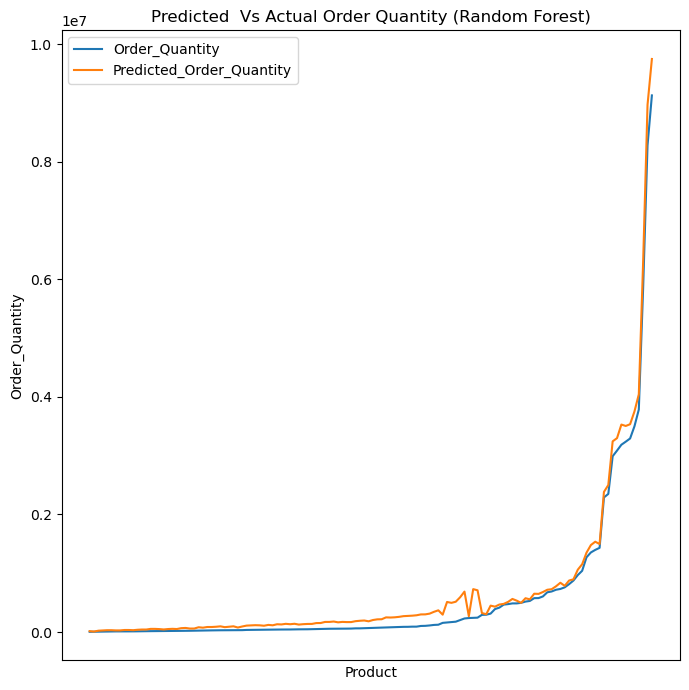

In [120]:
import matplotlib.pyplot as plt
# Create a subplot with 1 row and 1 column
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

Product_rf2_df = rf2_merged_df.groupby("Product")[['Order_Quantity','Predicted_Order_Quantity']].sum().reset_index().sort_values(by=['Order_Quantity'], ascending =True)

# Plot the top 10 products
Product_rf2_df.plot(kind='line', x='Product', y='Order_Quantity', ax=axes)
axes.set_xlabel("Product")
axes.set_ylabel("Order_Quantity")


# Plot the bottom 10 products
Product_rf2_df.plot(kind='line', x='Product', y='Predicted_Order_Quantity', ax=axes)
axes.set_xlabel("Product")
axes.set_ylabel("Order_Quantity")
axes.set_title("Predicted  Vs Actual Order Quantity (Random Forest)")
axes.set_xticks([])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


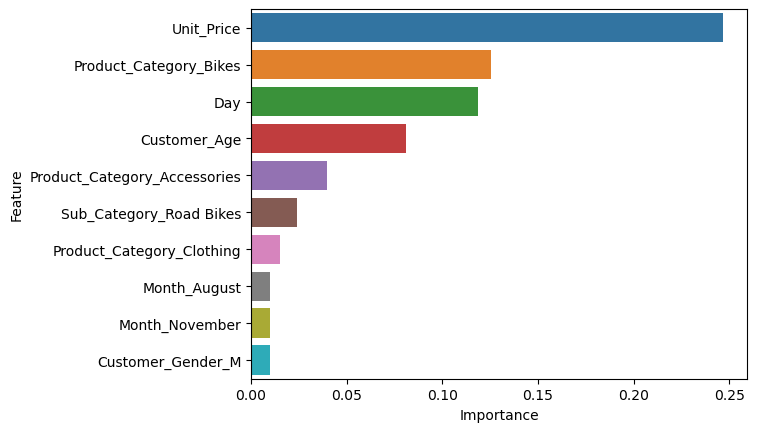

In [57]:
important_ft_2 = pd.DataFrame({"Feature" : X_train.columns, "Importance" : rf_2.feature_importances_}).sort_values(by="Importance",ascending=False).reset_index()
features_post_tuning = important_ft_2.head(20)['Feature'].to_list()
sns.barplot(data=important_ft_2.head(10), x='Importance', y='Feature');

# Model 2:  GBRegressor


In [58]:
gbm_1 = XGBRegressor(random_state=42, n_jobs=-1)

In [59]:
?XGBRegressor

In [60]:
data = [X_train, X_val, X_test]

for X in  data :
    X.columns=X.columns.str.replace(',', '_')
    X.columns=X.columns.str.replace("'", '')
    X.columns=X.columns.str.replace(" ", '')
    X.columns=X.columns.str.replace("<", 'less than')
    X.columns=X.columns.str.replace(">", 'more than')

In [61]:
gbm_1.fit(X_train,train_targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [62]:
train_preds_gbm1 = gbm_1.predict(X_train)
val_preds_gbm1 = gbm_1.predict(X_val)
test_preds_gbm1 = gbm_1.predict(X_test)


In [63]:
train_rmse_gbm1 = mean_squared_error(train_targets,train_preds_gbm1, squared=False)
val_rmse_gbm1 = mean_squared_error(val_targets,val_preds_gbm1, squared=False)
test_rmse_gbm1 = mean_squared_error(test_targets,test_preds_gbm1,squared = False)
print(train_rmse_gbm1,val_rmse_gbm1,test_rmse_gbm1)

7.0284439299885095 7.675100677255304 7.721569200164133


In [64]:
train_r2_gbm1 = r2_score(train_targets,train_preds_gbm1)
val_r2_gbm1 = r2_score(val_targets,val_preds_gbm1)
test_r2_gbm1 = r2_score(test_targets,test_preds_gbm1)
print(train_r2_gbm1,val_r2_gbm1,test_r2_gbm1)

0.46613028115649746 0.32730217375878135 0.31974907141067554


###### So we get an r2_score of :
###### `46.61%` on Training Data <br>
###### `32.73%` on Validation Data <br>
###### `31.97%` on Test Data <br>
######  We'll have to fine tune the hyperparameters to get a better value of the r2_scores

In [65]:
gbm_important_ft = pd.DataFrame({
    'feature': X.columns,
    'importance': gbm_1.feature_importances_
}).sort_values('importance', ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

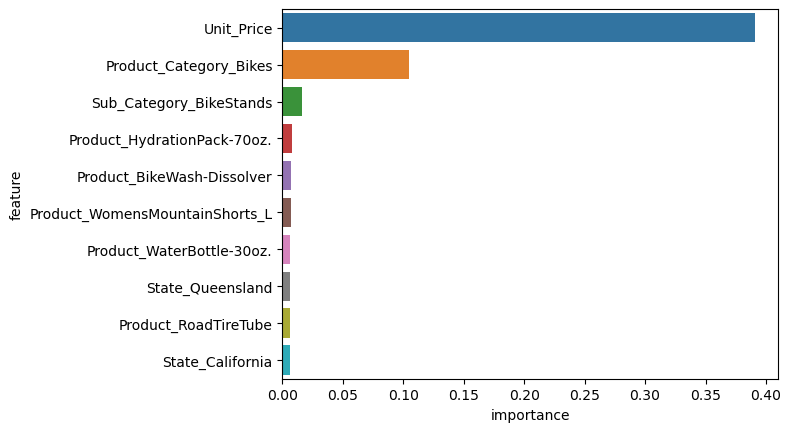

In [66]:
sns.barplot(data=gbm_important_ft.head(10), x='importance', y='feature')

# Hyperparameter Tuning : Model 2

In [76]:
def test_params_gbm(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets.values.ravel())
    train_rmse = mean_squared_error(model.predict(X_train), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val), val_targets, squared=False)
    return train_rmse, val_rmse

In [75]:
def test_param_and_plot_gbm(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params_gbm(**params)
        print(value,train_rmse, val_rmse)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

5 4.46580238357964 5.286521762620613
10 4.2581666134060105 5.017670315382427
15 4.182262685940365 4.899565864025067
20 4.14566465235571 4.861176855657937
50 4.080496426177036 4.766607827951333
100 4.057023278366785 4.742232140067803
150 4.049929417143838 4.734131553047216
500 4.03978323204108 4.721163209079626


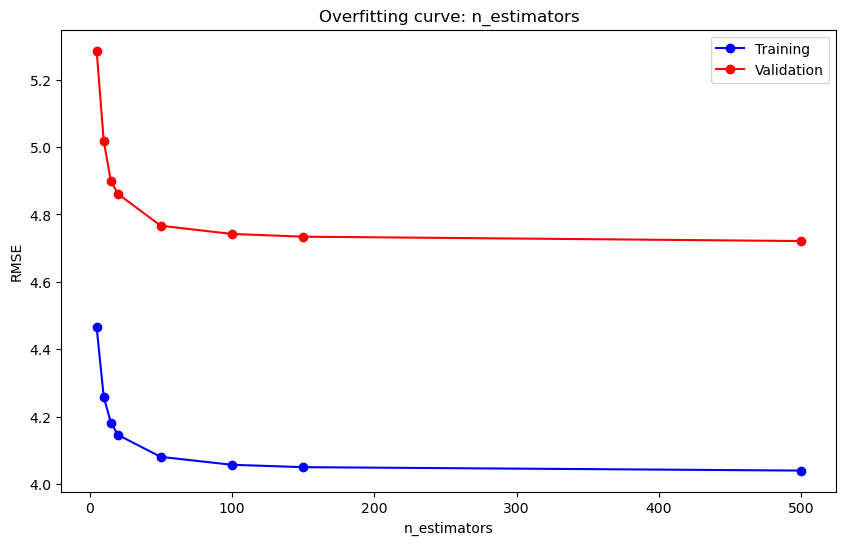

In [69]:
test_param_and_plot_gbm("n_estimators", [5,10,15,20,50,100,150,500]) 

##### Increasing number of trees result in decreased RMSE but to some extent, after 100 change is not very significant, so we'll stick with 100

5 7.438956318743959 7.981167001271137
10 7.315498258187953 7.890122537938564
20 6.395267033373283 7.149539698777173
50 4.087678304935623 4.792415523978178
100 4.057023278366785 4.742232140067803


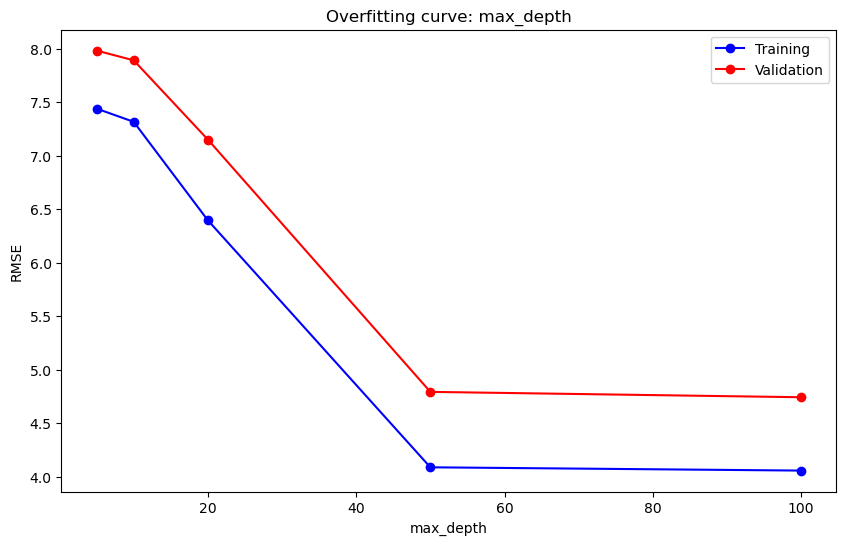

In [70]:
test_param_and_plot_gbm("max_depth", [5,10,20,50,100]) 

##### Max_Depth of 50 results in least Root Mean Sqaured Error so we'll go with that

depthwise 7.0284439299885095 7.675100677255304
lossguide 7.0284439299885095 7.675100677255304


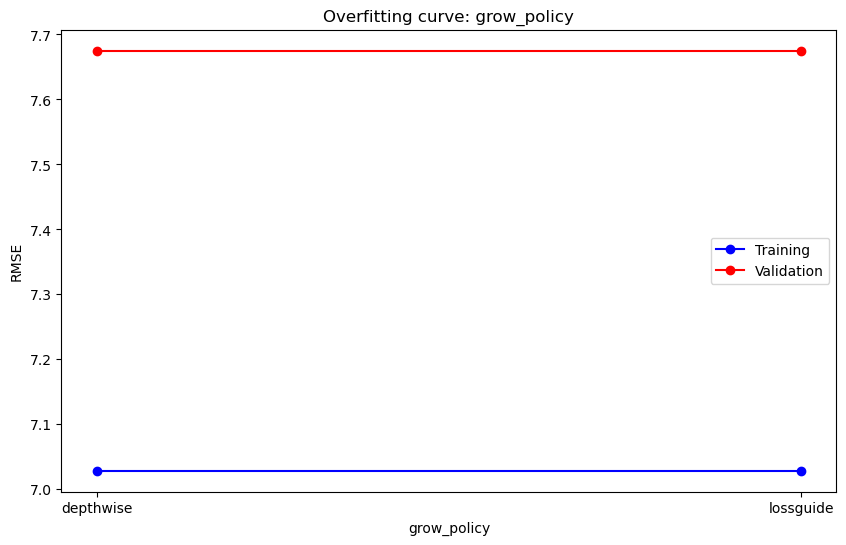

In [77]:
test_param_and_plot_gbm("grow_policy", ['depthwise', 'lossguide'])

###### Grow Policy doesnt have much effect on the RMSE values

In [78]:
gbm_2 = XGBRegressor(random_state=42, n_jobs=-1,n_estimators=100,max_depth=50)

In [79]:
gbm_2.fit(X_train,train_targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [80]:
train_preds_gbm2 = gbm_2.predict(X_train)
val_preds_gbm2 = gbm_2.predict(X_val)
test_preds_gbm2 = gbm_2.predict(X_test)

In [81]:
train_rmse_gbm2 = mean_squared_error(train_targets,train_preds_gbm2, squared=False)
val_rmse_gbm2 = mean_squared_error(val_targets,val_preds_gbm2, squared=False)
test_rmse_gbm2 = mean_squared_error(test_targets,test_preds_gbm2,squared = False)
print(train_rmse_gbm2,val_rmse_gbm2,test_rmse_gbm2)

3.762264924632239 4.165897010625321 4.23820044897757


In [82]:
train_r2_gbm2 = r2_score(train_targets,train_preds_gbm2)
val_r2_gbm2 = r2_score(val_targets,val_preds_gbm2)
test_r2_gbm2 = r2_score(test_targets,test_preds_gbm2)
print(train_r2_gbm2,val_r2_gbm2,test_r2_gbm2)

0.8470266890778695 0.8018158490036176 0.7950627077437765


In [83]:
test_targets = test_targets.reshape(14699,)
test_preds_gbm2 = test_preds_gbm2.reshape(14699,)

In [84]:
result_df = pd.DataFrame({
    'Order_Quantity': test_targets,
    'Predicted_Order_Quantity': test_preds_gbm2,
})

result_df

,Order_Quantity,Predicted_Order_Quantity
0,4,2.000104
1,17,18.999752
2,23,25.994587
3,17,13.000202
4,7,6.000862
...,...,...
14694,27,18.000193
14695,25,27.999088
14696,7,15.999723
14697,1,1.000028


In [87]:
merged_df = pd.merge(test_df, result_df, on='Order_Quantity')

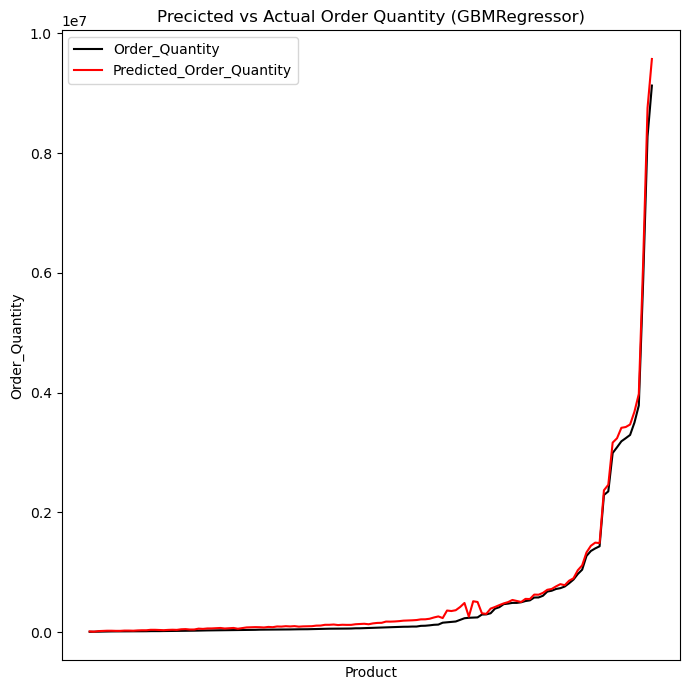

In [119]:
import matplotlib.pyplot as plt

# Create a subplot with 1 row and 1 column
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

Product_df = merged_df.groupby("Product")[['Order_Quantity','Predicted_Order_Quantity']].sum().reset_index().sort_values(by=['Order_Quantity'], ascending =True)

# Plot the top 10 products
Product_df.plot(kind='line', x='Product', y='Order_Quantity', ax=axes, color = 'black')
axes.set_xlabel("Product")
axes.set_ylabel("Order_Quantity")


# Plot the bottom 10 products
Product_df.plot(kind='line', x='Product', y='Predicted_Order_Quantity', ax=axes, color  = 'red')
axes.set_xlabel("Product")
axes.set_ylabel("Order_Quantity")
axes.set_title("Precicted vs Actual Order Quantity (GBMRegressor)")
axes.set_xticks([])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


###### So we get an r2_score of :
###### `84.70%` on Training Data <br>
###### `80.18%` on Validation Data <br>
###### `79.50%` on Test Data <br>
######  After choosing the right value for the right Hypeparameters, we can see that model's accuracy has increased, and now it's to some extent usable 

# Final Results:

#### We took sales data of a Bike Company, Data from stores of multiple countries, we studied the relation between customer  Demographics and Sales, Location of Store and Sale, and other parameters through exploratory data analysis.

#### Further we modelled this data using Random FOrest Regressor and Gradient Boosting Regressor, to predict the Order Quantity in the year 2016 based on the data from 2011 - 2015

#### Here are the final  key metrics related to both the models

#### For RandomForestRegressor :
| Data     | RMSE     | r2_score |
|----------|----------|----------|
| Train    | 4.04     | 82.34%   |
| Val      | 4.72     | 74.50%   |
| Test     | 4.77     | 73.98%   |

#### For GradientBoostingRegressor:
| Data     | RMSE     | r2_score |
|----------|----------|----------|
| Train    | 3.76     | 84.70%   |
| Val      | 4.16     | 80.18%   |
| Test     | 4.24     | 79.50%   |

# Saving the Models

In [133]:
bike_store_rf = {
    'model': rf_2,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(bike_store_rf, 'bike_store_rf.joblib')


['bike_store_rf.joblib']

In [134]:
bike_store_gbm = {
    'model': gbm_2,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(bike_store_gbm, 'bike_store_gbm.joblib')

['bike_store_gbm.joblib']

<h2><center> -- End of Project -- </center></h2>